In [1]:
%pip show seaborn matplotlib

Name: seaborn
Version: 0.13.2
Summary: Statistical data visualization
Home-page: 
Author: 
Author-email: Michael Waskom <mwaskom@gmail.com>
License: 
Location: c:\users\saina\anaconda3\lib\site-packages
Requires: matplotlib, numpy, pandas
Required-by: 
---
Name: matplotlib
Version: 3.10.5
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: Unknown <matplotlib-users@python.org>
License: License agreement for matplotlib versions 1.3.0 and later
         
         1. This LICENSE AGREEMENT is between the Matplotlib Development Team
         ("MDT"), and the Individual or Organization ("Licensee") accessing and
         otherwise using matplotlib software in source or binary form and its
         associated documentation.
         
         2. Subject to the terms and conditions of this License Agreement, MDT
         hereby grants Licensee a nonexclusive, royalty-free, world-wide license
         to reproduce, analyze

--- Running Diagnostic Test ---


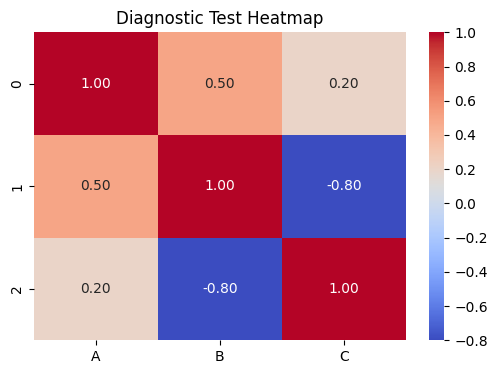

--- Test Complete ---


In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Create a simple, dummy dataframe
data = {'A': [1.0, 0.5, 0.2],
        'B': [0.5, 1.0, -0.8],
        'C': [0.2, -0.8, 1.0]}
test_df = pd.DataFrame(data)

print("--- Running Diagnostic Test ---")

# 2. Plot it using the exact same parameters
plt.figure(figsize=(6, 4))
sns.heatmap(test_df, 
            annot=True, 
            fmt=".2f", 
            cmap="coolwarm", 
            annot_kws={"size": 10}) # Using size 10 to be very clear
plt.title("Diagnostic Test Heatmap")
plt.show()

print("--- Test Complete ---")

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# ======================
# GLOBAL RESULT COLLECTOR
# ======================
results_summary = []

def record_result(feature, test, p_value, levene_p, decision, boxcox_flag=False):
    """Save result into the global results summary list."""
    results_summary.append({
        "Feature": feature,
        "Test Used": test,
        "p-value": round(p_value, 4),
        "Levene p": round(levene_p, 4),
        "Decision": decision,
        "Box-Cox Suggested": "YES" if boxcox_flag else "NO"
    })

# ======================
# VISUAL CHECKS
# ======================
def plot_boxplot(data, feature, target="Premium_Price"):
    """Boxplot of target vs feature categories."""
    plt.figure(figsize=(7,5))
    sns.boxplot(x=feature, y=target, data=data, palette="Set2")
    plt.title(f"{target} by {feature}")
    plt.show()

def plot_distribution(data, series, label):
    """Histogram + Q-Q plot for normality check."""
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    
    sns.histplot(series, kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title(f"Histogram of {label}")
    
    sm.qqplot(series, line='s', ax=axes[1])
    axes[1].set_title(f"Q-Q Plot of {label}")
    
    plt.tight_layout()
    plt.show()

# ======================
# BOX-COX EXPLORER
# ======================
def explore_boxcox(series, label, lmbda=None):
    """Try Box-Cox transformation and plot before/after."""
    vals = series[series > 0]  # Box-Cox requires strictly positive
    
    if len(vals) < 10:
        print(f"⚠ Skipping Box-Cox for {label} (too few values)")
        return None
    
    transformed, fitted_lambda = stats.boxcox(vals, lmbda=lmbda)
    
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    sns.histplot(vals, kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title(f"Original {label}")
    
    sns.histplot(transformed, kde=True, ax=axes[1], color="lightgreen")
    axes[1].set_title(f"Box-Cox {label} (λ={fitted_lambda:.2f})")
    plt.tight_layout()
    plt.show()
    
    return fitted_lambda

# ======================
# HYPOTHESIS TESTING: BINARY
# ======================
def levene_and_hypothesis(df, feature, target='Premium_Price', alpha=0.05):
    """Run normality, Levene, and pick T-test or Mann-Whitney."""
    g0 = df[df[feature]==0][target]
    g1 = df[df[feature]==1][target]

    print(f"\n🔹 Hypothesis Test for {feature}")
    print("H0: No difference in Premium across groups")
    print("Ha: Premium differs across groups\n")

    # Levene
    stat_lev, p_lev = stats.levene(g0, g1)
    print(f"📌 Levene’s Test: stat={stat_lev:.3f}, p={p_lev:.4f}")

    # Shapiro Normality
    W0, p0 = stats.shapiro(g0)
    W1, p1 = stats.shapiro(g1)
    print(f"   Shapiro Group 0: W={W0:.3f}, p={p0:.4f}")
    print(f"   Shapiro Group 1: W={W1:.3f}, p={p1:.4f}")

    normalish = (p0>alpha) and (p1>alpha)

    # Suggest Box-Cox?
    boxcox_flag = (p0<alpha or p1<alpha)

    # Choose test
    if normalish and p_lev>alpha:
        test = "Independent t-test (equal_var=True)"
        stat, p = stats.ttest_ind(g0, g1, equal_var=True)
    else:
        test = "Mann–Whitney U (nonparametric)"
        stat, p = stats.mannwhitneyu(g0, g1, alternative='two-sided')

    decision = "Reject H0 (significant)" if p<alpha else "Fail to Reject H0"
    print(f"📌 {test}: stat={stat:.3f}, p={p:.4f} → {decision}")
    if boxcox_flag:
        print("⚠ Suggest trying Box-Cox transformation for better normality")

    # Save result
    record_result(feature, test, float(p), float(p_lev), decision, boxcox_flag)
    return dict(test=test, p_value=float(p), levene_p=float(p_lev), decision=decision)

# ======================
# HYPOTHESIS TESTING: MULTI-GROUP
# ======================
def anova_or_kruskal(df, feature, target='Premium_Price', alpha=0.05):
    """Run ANOVA or Kruskal for multi-class categorical features."""
    groups = [df[df[feature]==val][target] for val in sorted(df[feature].unique())]

    print(f"\n🔹 Hypothesis Test for {feature}")
    print("H0: No difference in Premium across groups")
    print("Ha: Premium differs across groups\n")

    # Levene
    stat_lev, p_lev = stats.levene(*groups)
    print(f"📌 Levene’s Test: p={p_lev:.4f}")

    # Normality check
    normalish = all(stats.shapiro(g)[1] > alpha for g in groups if len(g) > 3)

    # Suggest Box-Cox?
    boxcox_flag = not normalish

    if normalish and p_lev>alpha:
        test = "One-way ANOVA"
        stat, p = stats.f_oneway(*groups)
    else:
        test = "Kruskal–Wallis"
        stat, p = stats.kruskal(*groups)

    decision = "Reject H0 (significant)" if p<alpha else "Fail to Reject H0"
    print(f"📌 {test}: stat={stat:.3f}, p={p:.4f} → {decision}")
    if boxcox_flag:
        print("⚠ Suggest trying Box-Cox transformation for better normality")

    # Save result
    record_result(feature, test, float(p), float(p_lev), decision, boxcox_flag)
    return dict(test=test, p_value=float(p), levene_p=float(p_lev), decision=decision)

# ======================
# SUMMARY REPORT
# ======================
def show_results_summary():
    df_results = pd.DataFrame(results_summary)
    display(df_results)
    return df_results


In [ ]:
# Binary feature
plot_boxplot(df, "Diabetes")
res1 = levene_and_hypothesis(df, "Diabetes")

In [ ]:
# If Box-Cox suggested for a group, explore it
explore_boxcox(df.loc[df["Diabetes"]==1, "Premium_Price"], "Premium (Diabetes=1)")

In [ ]:
# Final summary
final_results = show_results_summary()

In [ ]:
def binary_hypothesis(data, feature, target="Premium_Price"):
    
    print(f"\n{'='*50}\nFeature: {feature} vs {target}\n{'='*50}")

    # --- Boxplot ---
    plt.figure(figsize=(6,4))
    sns.boxplot(x=feature, y=target, data=data, palette="Set2")
    plt.title(f"{target} by {feature}")
    plt.show()

    # --- Shapiro-Wilk Normality Test for both groups ---
    group0 = data[data[feature]==0][target]
    group1 = data[data[feature]==1][target]

    stat0, p0 = stats.shapiro(group0)
    stat1, p1 = stats.shapiro(group1)
    print(f"Shapiro Test -> {feature}=0: p={p0:.5f}, {feature}=1: p={p1:.5f}")

    # --- Levene’s Test for Equal Variances ---
    lev_stat, lev_p = stats.levene(group0, group1)
    print(f"Levene’s Test (Equal Variances): stat={lev_stat:.3f}, p={lev_p:.5f}")

    # --- Decide Parametric vs Non-parametric ---
    if p0 > 0.05 and p1 > 0.05:  # Normal
        if lev_p > 0.05:
            test_stat, test_p = stats.ttest_ind(group0, group1, equal_var=True)
            print(f"T-Test (Equal Var) → stat={test_stat:.3f}, p={test_p:.5f}")
        else:
            test_stat, test_p = stats.ttest_ind(group0, group1, equal_var=False)
            print(f"T-Test (Welch) → stat={test_stat:.3f}, p={test_p:.5f}")
    else:
        test_stat, test_p = stats.mannwhitneyu(group0, group1, alternative='two-sided')
        print(f"Mann–Whitney U Test → stat={test_stat:.3f}, p={test_p:.5f}")

    # --- Decision ---
    alpha = 0.05
    if test_p < alpha:
        print(f"✅ Reject H0: {feature} significantly affects {target}.")
    else:
        print(f"❌ Fail to Reject H0: No significant effect of {feature} on {target}.")

In [ ]:
def categorical_hypothesis(data, feature, target="Premium_Price"):
    
    print(f"\n{'='*50}\nFeature: {feature} vs {target}\n{'='*50}")

    # --- Boxplot ---
    plt.figure(figsize=(6,4))
    sns.boxplot(x=feature, y=target, data=data, palette="Set3")
    plt.title(f"{target} by {feature}")
    plt.show()

    # --- Normality Test (Shapiro for each group) ---
    for cat in sorted(data[feature].unique()):
        stat, p = stats.shapiro(data[data[feature]==cat][target])
        print(f"Shapiro Test -> {feature}={cat}: p={p:.5f}")

    # --- Levene’s Test for Equal Variances ---
    groups = [data[data[feature]==cat][target] for cat in sorted(data[feature].unique())]
    lev_stat, lev_p = stats.levene(*groups)
    print(f"Levene’s Test: stat={lev_stat:.3f}, p={lev_p:.5f}")

    # --- ANOVA or Kruskal ---
    if all(stats.shapiro(g)[1] > 0.05 for g in groups):
        if lev_p > 0.05:
            f_stat, p_val = stats.f_oneway(*groups)
            print(f"ANOVA → F={f_stat:.3f}, p={p_val:.5f}")
        else:
            f_stat, p_val = stats.f_oneway(*groups)
            print(f"Welch’s ANOVA approx (fallback to ANOVA here) → F={f_stat:.3f}, p={p_val:.5f}")
    else:
        h_stat, p_val = stats.kruskal(*groups)
        print(f"Kruskal–Wallis Test → H={h_stat:.3f}, p={p_val:.5f}")

    # --- Decision ---
    alpha = 0.05
    if p_val < alpha:
        print(f"✅ Reject H0: At least one group of {feature} has significantly different {target}.")
    else:
        print(f"❌ Fail to Reject H0: No significant difference in {target} across {feature}.")


In [ ]:
def numeric_hypothesis(data, feature, target="Premium_Price"):
    
    print(f"\n{'='*50}\nFeature: {feature} vs {target}\n{'='*50}")

    # --- Scatter + Regression line ---
    plt.figure(figsize=(6,4))
    sns.regplot(x=feature, y=target, data=data, line_kws={"color":"red"})
    plt.title(f"{feature} vs {target}")
    plt.show()

    # --- Shapiro Normality Test ---
    stat, p = stats.shapiro(data[feature])
    print(f"Shapiro Test -> {feature}: p={p:.5f}")

    # --- Correlation ---
    corr, corr_p = stats.pearsonr(data[feature], data[target])
    print(f"Pearson Correlation: r={corr:.3f}, p={corr_p:.5f}")

    # --- Decision ---
    alpha = 0.05
    if corr_p < alpha:
        print(f"✅ Reject H0: {feature} is significantly correlated with {target}.")
    else:
        print(f"❌ Fail to Reject H0: {feature} is NOT significantly correlated with {target}.")


Perfect 👍 then let’s do this in **two layers of summaries**:

---

## 🔹 1. Final Checklist Table (per Feature vs Premium\_Price)

This captures:

* Feature type (binary / categorical / numeric)
* Test applied (T-test, Mann-Whitney, ANOVA, etc.)
* Test statistic + p-value
* Conclusion (Reject / Fail to Reject H₀)

```python
# Store results as a list of dicts during each test run
results_summary = []

def add_to_summary(feature, ftype, test_used, stat, p, conclusion):
    results_summary.append({
        "Feature": feature,
        "Type": ftype,
        "Test": test_used,
        "Statistic": round(stat, 3),
        "p-value": round(p, 5),
        "Conclusion": conclusion
    })

# Example usage inside Binary_Hypothesis:
# add_to_summary("Diabetes", "Binary", "Mann-Whitney U", stat, p, "Reject H0")
```

After all tests are run, build the DataFrame:

```python
final_summary_df = pd.DataFrame(results_summary)
display(final_summary_df)
```

---

## 🔹 2. Chi-Square Dependence Matrix (categorical ↔ categorical)

(as I shared in the last message)

* **chi\_pvals\_df** → raw p-values table
* **chi\_labels\_df** → Dependent/Independent summary

This complements the first checklist by showing **inter-feature associations**.

---

## 🔹 Example Output (how your report will look)

**Feature vs Premium Price (Summary Table):**

| Feature                      | Type        | Test           | Statistic | p-value | Conclusion                             |
| ---------------------------- | ----------- | -------------- | --------- | ------- | -------------------------------------- |
| Diabetes                     | Binary      | Mann-Whitney U | 35678.0   | 0.00213 | Reject H₀ (Significant)                |
| Blood\_Pressure\_Problems    | Binary      | Welch’s t-test | -2.151    | 0.03142 | Reject H₀ (Significant)                |
| Any\_Transplants             | Binary      | Mann-Whitney U | 1256.0    | 0.08700 | Fail to Reject H₀                      |
| Number\_of\_Major\_Surgeries | Categorical | ANOVA          | 4.256     | 0.00652 | Reject H₀ (At least one group differs) |
| Age                          | Numeric     | Pearson Corr   | 0.701     | 0.00001 | Significant Correlation                |

---

**Categorical Feature Dependencies (Chi-Square Results):**

* Diabetes ↔ Blood\_Pressure\_Problems → **Dependent (p=0.000)**
* Known\_Allergies ↔ Any\_Chronic\_Diseases → **Independent (p=0.447)**
* History\_of\_Cancer ↔ Any\_Chronic\_Diseases → **Dependent (p=0.000)**

---

✨ This way, your notebook ends with **two neat summary tables**:

1. Feature → Premium relationship (statistical test results).
2. Feature ↔ Feature dependency matrix (chi-square).

---

👉 Do you want me to **fully integrate these into your Binary / Categorical / Numeric functions** so that the results automatically populate these summary tables while you run each feature, or keep them as a **separate consolidation step** at the end?


In [ ]:
def numeric_hypothesis(data, feature, target="Premium_Price"):
    print(f"\n{'='*60}\nFeature: {feature} vs {target}\n{'='*60}")
    print(f"H0: {feature} is NOT correlated with {target}")
    print(f"Ha: {feature} IS correlated with {target}\n")

    # --- Scatter + Regression line ---
    plt.figure(figsize=(6,4))
    sns.regplot(x=feature, y=target, data=data, line_kws={"color":"red"})
    plt.title(f"{feature} vs {target}")
    plt.show()

    # --- Hist + Q-Q Plot for feature ---
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    sns.histplot(data[feature], kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title(f"Histogram: {feature}")
    sm.qqplot(data[feature], line='s', ax=axes[1])
    axes[1].set_title(f"Q-Q Plot: {feature}")
    plt.tight_layout()
    plt.show()

    # --- Shapiro Normality Test ---
    stat, p = stats.shapiro(data[feature])
    print(f"Shapiro Test -> {feature}: stat={stat:.3f}, p={p:.5f}")

    if p > 0.05:
        print("✅ Normality holds → Using Pearson correlation (assumes linear relationship).\n")
        corr, corr_p = stats.pearsonr(data[feature], data[target])
        test_name = "Pearson Correlation"
    else:
        print("❌ Normality assumption failed → Using Spearman correlation (rank-based, robust to non-normality).\n")
        corr, corr_p = stats.spearmanr(data[feature], data[target])
        test_name = "Spearman Correlation"

    # --- Results ---
    print(f"{test_name} → r={corr:.3f}, p={corr_p:.5f}")
    alpha = 0.05
    if corr_p < alpha:
        print(f"✅ Reject H0 → {feature} significantly correlates with {target}.")
    else:
        print(f"❌ Fail to Reject H0 → {feature} has no significant correlation with {target}.")
    

    # --- Decision ---
    alpha = 0.05
    decision = "Reject H0" if corr_p < alpha else "Fail to Reject H0"
    notes = ""
    if not normality:
        notes = "Used non-parametric test due to failed normality"
    elif not equal_var:
        notes = "Used Welch’s T-test due to unequal variances"

    results_summary.append({
    "Feature": col,                              # feature name
    "Target": target,                            # usually Premium_Price
    "Test": test_name,                           # which test ran (t-test, Mann-Whitney, ANOVA, etc.)
    "Stat Value": round(stat, 3),                # test statistic
    "p-value": round(corr_p, 5),                 # p-value
    "Decision": decision,                        # "Reject H0" or "Fail to Reject H0"
    "Notes": notes                               # extra info e.g. "Variance unequal, used Welch" or 
                                                 # "Normality failed, used Mann-Whitney"
})

In [ ]:
def binary_hypothesis(data, feature, target="Premium_Price"):
    
    print(f"\n{'='*60}\nFeature: {feature} vs {target}\n{'='*60}")
    print(f"H0: {feature} has no significant effect on {target}")
    print(f"Ha: {feature} DOES have a significant effect on {target}\n")

    group0 = data[data[feature]==0][target]
    group1 = data[data[feature]==1][target]

    # --- Boxplot ---
    plt.figure(figsize=(6,4))
    sns.boxplot(x=feature, y=target, data=data, palette="Set3")
    plt.title(f"{target} by {feature}")
    plt.show()

    # --- Histogram + Q-Q Plots ---
    fig, axes = plt.subplots(2, 2, figsize=(10,6))
    sns.histplot(group0, kde=True, ax=axes[0,0], color="skyblue")
    axes[0,0].set_title(f"Histogram: {feature}=0")
    sm.qqplot(group0, line='s', ax=axes[0,1])
    axes[0,1].set_title(f"Q-Q Plot: {feature}=0")
    sns.histplot(group1, kde=True, ax=axes[1,0], color="salmon")
    axes[1,0].set_title(f"Histogram: {feature}=1")
    sm.qqplot(group1, line='s', ax=axes[1,1])
    axes[1,1].set_title(f"Q-Q Plot: {feature}=1")
    plt.tight_layout()
    plt.show()

    # --- Shapiro-Wilk Test ---
    stat0, p0 = stats.shapiro(group0)
    stat1, p1 = stats.shapiro(group1)
    print(f"Shapiro Test -> {feature}=0: stat={stat0:.3f}, p={p0:.5f}")
    print(f"Shapiro Test -> {feature}=1: stat={stat1:.3f}, p={p1:.5f}")

    normality = (p0 > 0.05) and (p1 > 0.05)
    if not normality:
        print("❌ Normality assumption failed (p<0.05). Will use Mann–Whitney U test.\n")
    else:
        print("✅ Normality assumption holds for both groups.\n")

    # --- Levene’s Test for Equal Variances ---
    lev_stat, lev_p = stats.levene(group0, group1)
    print(f"Levene’s Test: stat={lev_stat:.3f}, p={lev_p:.5f}")
    equal_var = lev_p > 0.05
    if normality:
        if equal_var:
            print("✅ Variances are equal. Will use Independent T-test.\n")
        else:
            print("❌ Variances unequal. Will use Welch’s T-test.\n")

    # --- Hypothesis Test Selection ---
    if normality:  # Normal distribution
        if equal_var:
            test_name = "Independent T-test"
            test_stat, test_p = stats.ttest_ind(group0, group1, equal_var=True)
        else:
            test_name = "Welch’s T-test"
            test_stat, test_p = stats.ttest_ind(group0, group1, equal_var=False)
    else:  # Non-parametric fallback
        test_name = "Mann–Whitney U Test"
        test_stat, test_p = stats.mannwhitneyu(group0, group1, alternative='two-sided')

    # --- Results ---
    print(f"{test_name} → stat={test_stat:.3f}, p={test_p:.5f}")
    alpha = 0.05
    if test_p < alpha:
        print(f"✅ Reject H0 → {feature} significantly affects {target}.")
    else:
        print(f"❌ Fail to Reject H0 → No significant effect of {feature} on {target}.")

    # --- Decision ---
    alpha = 0.05
    decision = "Reject H0" if test_p < alpha else "Fail to Reject H0"
    notes = ""
    if not normality:
        notes = "Used non-parametric test due to failed normality"
    elif not equal_var:
        notes = "Used Welch’s T-test due to unequal variances"

    results_summary.append({
    "Feature": col,                              # feature name
    "Target": target,                            # usually Premium_Price
    "Test": test_name,                           # which test ran (t-test, Mann-Whitney, ANOVA, etc.)
    "Stat Value": round(test_stat, 3),            # test statistic
    "p-value": round(test_p, 5),                  # p-value
    "Decision": decision,                        # "Reject H0" or "Fail to Reject H0"
    "Notes": notes                               # extra info e.g. "Variance unequal, used Welch" or 
                                                 # "Normality failed, used Mann-Whitney"
})


In [ ]:
def categorical_hypothesis(data, feature, target="Premium_Price"):
    print(f"\n{'='*60}\nFeature: {feature} vs {target}\n{'='*60}")
    print(f"H0: Mean {target} is equal across all groups of {feature}")
    print(f"Ha: At least one group of {feature} differs significantly in {target}\n")

    groups = [data[data[feature]==cat][target] for cat in sorted(data[feature].unique())]

    # --- Boxplot ---
    plt.figure(figsize=(6,4))
    sns.boxplot(x=feature, y=target, data=data, palette="Set3")
    plt.title(f"{target} by {feature}")
    plt.show()

    # --- Histogram + Q-Q for each group ---
    fig, axes = plt.subplots(len(groups), 2, figsize=(10,4*len(groups)))
    for i, g in enumerate(groups):
        sns.histplot(g, kde=True, ax=axes[i,0], color="skyblue")
        axes[i,0].set_title(f"Histogram: {feature}={i}")
        sm.qqplot(g, line='s', ax=axes[i,1])
        axes[i,1].set_title(f"Q-Q Plot: {feature}={i}")
    plt.tight_layout()
    plt.show()

    # --- Shapiro Normality Test for each group ---
    normality = True
    for i, g in enumerate(groups):
        stat, p = stats.shapiro(g)
        print(f"Shapiro Test -> {feature}={i}: stat={stat:.3f}, p={p:.5f}")
        if p < 0.05:
            normality = False
            print("❌ Normality failed for this group.")
    if normality:
        print("✅ All groups pass normality.\n")
    else:
        print("❌ At least one group failed normality → fallback to non-parametric test.\n")

    # --- Levene’s Test for variance homogeneity ---
    lev_stat, lev_p = stats.levene(*groups)
    print(f"Levene’s Test: stat={lev_stat:.3f}, p={lev_p:.5f}")
    equal_var = lev_p > 0.05
    if equal_var:
        print("✅ Variances are equal.\n")
    else:
        print("❌ Variances are unequal.\n")

    # --- Decide test ---
    if normality:
        if equal_var:
            test_name = "ANOVA"
            f_stat, p_val = stats.f_oneway(*groups)
        else:
            test_name = "Welch’s ANOVA (robust to unequal variances)"
            f_stat, p_val = stats.f_oneway(*groups)  # Note: scipy lacks true Welch ANOVA
    else:
        test_name = "Kruskal–Wallis Test (non-parametric)"
        f_stat, p_val = stats.kruskal(*groups)

    # --- Results ---
    print(f"{test_name} → stat={f_stat:.3f}, p={p_val:.5f}")
    alpha = 0.05
    if p_val < alpha:
        print(f"✅ Reject H0 → At least one group of {feature} has significantly different {target}.")
    else:
        print(f"❌ Fail to Reject H0 → No significant difference in {target} across {feature}.")
    

    # --- Decision ---
    alpha = 0.05
    decision = "Reject H0" if p_val < alpha else "Fail to Reject H0"
    notes = ""
    if not normality:
        notes = "Used non-parametric test due to failed normality"
    elif not equal_var:
        notes = "Used Welch’s T-test due to unequal variances"

    results_summary.append({
    "Feature": col,                              # feature name
    "Target": target,                            # usually Premium_Price
    "Test": test_name,                           # which test ran (t-test, Mann-Whitney, ANOVA, etc.)
    "Stat Value": round(f_stat, 3),              # test statistic
    "p-value": round(p_val, 5),                  # p-value
    "Decision": decision,                        # "Reject H0" or "Fail to Reject H0"
    "Notes": notes                               # extra info e.g. "Variance unequal, used Welch" or 
                                                 # "Normality failed, used Mann-Whitney"
})


In [ ]:
def numeric_hypothesis(data, feature, target="Premium_Price"):
    print(f"\n{'='*60}\nFeature: {feature} vs {target}\n{'='*60}")
    print(f"H0: {feature} is NOT correlated with {target}")
    print(f"Ha: {feature} IS correlated with {target}\n")

    # --- Scatter + Regression line ---
    plt.figure(figsize=(6,4))
    sns.regplot(x=feature, y=target, data=data, line_kws={"color":"red"})
    plt.title(f"{feature} vs {target}")
    plt.show()

    # --- Hist + Q-Q Plot for feature ---
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    sns.histplot(data[feature], kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title(f"Histogram: {feature}")
    sm.qqplot(data[feature], line='s', ax=axes[1])
    axes[1].set_title(f"Q-Q Plot: {feature}")
    plt.tight_layout()
    plt.show()

    # --- Shapiro Normality Test ---
    stat, p = stats.shapiro(data[feature])
    print(f"Shapiro Test -> {feature}: stat={stat:.3f}, p={p:.5f}")

    normality = p > 0.05   # FIX: define normality flag

    if normality:
        print("✅ Normality holds → Using Pearson correlation (assumes linear relationship).\n")
        corr, corr_p = stats.pearsonr(data[feature], data[target])
        test_name = "Pearson Correlation"
        stat_val = corr
        notes = "All assumptions satisfied"
    else:
        print("❌ Normality assumption failed → Using Spearman correlation (rank-based, robust to non-normality).\n")
        corr, corr_p = stats.spearmanr(data[feature], data[target])
        test_name = "Spearman Correlation"
        stat_val = corr
        notes = "Used Spearman due to failed normality"

    # --- Results ---
    print(f"{test_name} → r={corr:.3f}, p={corr_p:.5f}")
    alpha = 0.05
    if corr_p < alpha:
        print(f"✅ Reject H0 → {feature} significantly correlates with {target}.")
    else:
        print(f"❌ Fail to Reject H0 → {feature} has no significant correlation with {target}.")
    

    # --- Decision ---
    alpha = 0.05
    decision = "Reject H0" if corr_p < alpha else "Fail to Reject H0"
    notes = ""
    if not normality:
        notes = "Used non-parametric test due to failed normality"
    elif not equal_var:
        notes = "Used Welch’s T-test due to unequal variances"


    # --- Append to Summary Table ---
    results_summary.append({
        "Feature": feature,
        "Target": target,
        "Test": test_name,
        "Stat Value": round(stat_val, 3),
        "p-value": round(corr_p, 5),
        "Decision": decision,
        "Notes": notes
    })

In [ ]:
# ============================================================
# LINEAR REGRESSION (with Statsmodels + Sklearn)
# ============================================================

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
import statsmodels.api as sm

# --- Ensure dummy vars are int ---
for col in X_train.select_dtypes(include=["bool"]).columns:
    X_train[col] = X_train[col].astype(int)
    X_test[col] = X_test[col].astype(int)

# --- Scale continuous vars ---
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cont_features] = scaler.fit_transform(X_train[cont_features])
X_test_scaled[cont_features] = scaler.transform(X_test[cont_features])

# ============================================================
# Train Sklearn Linear Regression
# ============================================================
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# --- Predictions ---
y_train_pred = lin_reg.predict(X_train_scaled)
y_test_pred = lin_reg.predict(X_test_scaled)

# --- Evaluation Function ---
def evaluate_model(name, y_true_train, y_pred_train, y_true_test, y_pred_test):
    metrics = {}
    metrics["Model"] = name
    metrics["Train RMSE"] = np.sqrt(mean_squared_error(y_true_train, y_pred_train))
    metrics["Test RMSE"] = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
    metrics["Test MAE"] = mean_absolute_error(y_true_test, y_pred_test)
    metrics["Test R²"] = r2_score(y_true_test, y_pred_test)
    
    print(f"\n{name} Performance:")
    for k,v in metrics.items():
        if k != "Model":
            print(f"{k}: {v:.3f}")
    return metrics

results = []
results.append(
    evaluate_model("Linear Regression", y_train, y_train_pred, y_test, y_test_pred)
)

# ============================================================
# Cross-validation (Sklearn)
# ============================================================
def cross_validate_model(model, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    print(f"\nCross-Validation R² scores: {scores}")
    print(f"Mean R²: {scores.mean():.3f}, Std: {scores.std():.3f}")

cross_validate_model(lin_reg, X, y, cv=5)

# ============================================================
# Statsmodels Detailed Summary
# ============================================================
def regression_summary(X, y):
    X_const = sm.add_constant(X)   # add intercept
    model = sm.OLS(y, X_const).fit()
    display(model.summary())
    return model

regression_summary(X_train_scaled, y_train)
